# Multi-Scenario MORDM


Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [1]:
# 1) import model and functionalities
from ema_workbench import Model, RealParameter, ScalarOutcome, SequentialEvaluator, MultiprocessingEvaluator, ema_logging, Policy

In [2]:
from scipy.optimize import brentq
import math
nfe_value = 50000

In [3]:
import numpy as np

#THE FUNCTION FOR ANTHROPOGENIC POLLUTION FOR CLOSED LOOP CONTROL
def a_t(X, #x is a scalar, pollution at time t
        c=[],
        r=[],
        w=[],
        n=2):

    a = sum([w[j]*(abs((X-c[j])/r[j]))**3 for j in range(n)])
    return min(max(a, 0.01), 0.1)

##### Model implementation
closed loop model was chosen to impement

In [4]:
import numpy as np
from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant)
from dps_lake_model import lake_model
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)



ema_logging.log_to_stderr(ema_logging.INFO)
lake_model = Model('lakeproblem', function=lake_model)
lake_model.time_horizon = 100 

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

#set levers
lake_model.levers = [RealParameter("c1", -2, 2),
                     RealParameter("c2", -2, 2),
                     RealParameter("r1", 0, 2),
                     RealParameter("r2", 0, 2),
                     RealParameter("w1", 0, 1)]

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE, expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MINIMIZE, expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,1))]

In [5]:
#convergence metrics
convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

##### Perform Experiments

In [6]:
import os

from ema_workbench import (perform_experiments, ema_logging, save_results, 
                           load_results, Policy)
from ema_workbench.em_framework import samplers
from ema_workbench.em_framework import sample_levers

# turn on logging
ema_logging.log_to_stderr(ema_logging.INFO)

# perform experiments
nr_experiments = 500

policies = sample_levers(lake_model,n_samples=5)
results = perform_experiments(lake_model, nr_experiments, policies=policies)


[MainProcess/INFO] performing 500 scenarios * 5 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


#### From Quakkels website
Step 2.2: Select policy relevant scenarios based on the exploration results:
   - max_P >= median(~ 5)
   - reliability <= median (~0.5)
   - inertia <= median (~1)
   - utility <= median (~0.15)

#### Create four scenarios?
# Step 2.2: Select policy relevant scenarios based on the exploration results:
This was done in the paper by Kwakkel et al by tresholds for values calculated out of the outcomes, and then from these 4 maximally diverse scenarios are chosen to make sure that there is a big enoug representation of the data set.


In [7]:
experiments, outcomes = results
oois = sorted(outcomes.keys())

In [8]:
print(outcomes)

{'max_P': array([4.70595903, 5.8210212 , 4.67114623, ..., 2.92057198, 0.40893791,
       5.11317668]), 'utility': array([0.58605946, 0.63591988, 1.49294668, ..., 0.64748614, 0.5809145 ,
       1.90955545]), 'inertia': array([0.99, 0.99, 0.99, ..., 0.99, 0.99, 0.99]), 'reliability': array([0.05  , 0.0613, 0.07  , ..., 0.06  , 1.    , 0.07  ])}


In [9]:
#here, the policy-relevant scenarios defined by median thresholds are selected
indices = []
for ooi in oois:
    if ooi in ['max_P', 'inertia']:
        a = outcomes[ooi] > np.median(outcomes[ooi])     
    else: 
        a = outcomes[ooi] < np.median(outcomes[ooi])
    indices.append(a)
indices = np.swapaxes(indices, 0, 1)
logical_index = np.array([index.all() for index in indices])
newExperiments = experiments[logical_index]
newOutcomes = {}
for ooi in oois:
    newOutcomes[ooi] = outcomes[ooi][logical_index]
newResults = newExperiments, newOutcomes

In [10]:
print(len(newOutcomes['max_P']))

0


In [11]:
new_fn = '206_experiments_openloop_Apollution.tar.gz'
save_results(newResults, new_fn)

[MainProcess/INFO] results saved successfully to E:\Onedrive\Documenten\Universiteit\Delft\Q4-2020\Model-based-Decision-making\Assignments\FabiosDecisions\epa1361\Week-5-6-robustness-and-direct-search\206_experiments_openloop_Apollution.tar.gz


##### Results from the scenario-selection file
Now these results can be analyzed with the scenario-selection file.

Results: maximum diversity and solutions: 1.0307457510054456, [[array([ 21,  28,  33, 104])]]

In [12]:
#Find the Maximally diverse: 
import pandas as pd
import copy
#0 : non policy-relevant scenarios
#1 : policy-relevant scenarios
#2 : prim results
#3 : diverse SELECTED
#4 : random selected

sel_column = logical_index.astype(int)
selected = [ 21,  28,  33, 104]
random_selected = [81, 289, 391, 257]
count = 0
for index, i in enumerate(sel_column):
    
    if logical_index[index]: #this is computed at the bottom of  the notebook
        sel_column[index] = 2
    if i:
        if count in selected:
            sel_column[index] = 3
        count +=1 #the reason for the count is that the selected indices correspond to the dataset of 206 scenarios 
            
    if index in random_selected:
        sel_column[index] = 4
        
print(len(sel_column))

2500


## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


#### Prepare the scenarios for usage

In [13]:
np.partition(outcomes["utility"],4)[:4]

array([0.5343345 , 0.54002752, 0.53902854, 0.54323928])

In [14]:
list_utility = outcomes["utility"].tolist()

In [15]:
list_chosen = sorted(range(len(list_utility)), key=lambda k: list_utility[k])[:4]  
sorted(range(len(list_utility)), key=lambda k: list_utility[k])[:4]

[1173, 1217, 1421, 1447]

In [16]:
#list_chosen = [169, 162, 170, 140]
selected_scenarios = experiments.iloc[list_chosen,:].copy()
scenarios_dictlist = selected_scenarios.to_dict("records")
selected_scenarios

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model
1173,0.396239,0.930518,0.025179,2.614073,0.002206,1.983579,0.738997,1.693728,1.606864,0.172213,173,2,lakeproblem
1217,0.246795,0.930025,0.027991,3.347887,0.003772,1.983579,0.738997,1.693728,1.606864,0.172213,217,2,lakeproblem
1421,0.231393,0.930171,0.034504,2.692232,0.002584,1.983579,0.738997,1.693728,1.606864,0.172213,421,2,lakeproblem
1447,0.323260,0.930322,0.032364,3.753481,0.003284,1.983579,0.738997,1.693728,1.606864,0.172213,447,2,lakeproblem


##### to use the scenarios later, drop unecessary columns. Otherwise the .optimeze does not work


In [17]:
selected_scenarios.drop(columns = ['c1','model', 'c2', 'r1', 'r2', 'w1', 'scenario', 'policy'], inplace = True)

In [18]:
selected_scenarios
scenarios_dictlist = selected_scenarios.to_dict("records")

#### Use the found scenarios

In [19]:
from ema_workbench import Scenario
scenario_1 = Scenario("1", **scenarios_dictlist[0])
scenario_2 = Scenario("2", **scenarios_dictlist[1])
scenario_3 = Scenario("3", **scenarios_dictlist[2])
scenario_4 = Scenario("4", **scenarios_dictlist[3])

In [20]:
from ema_workbench import MultiprocessingEvaluator
from ema_workbench import ema_logging
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import Constraint

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

constraints = [Constraint("max pollution", outcome_names="max_P",
                          function=lambda x:max(0, x-1))]

with MultiprocessingEvaluator(lake_model) as evaluator:
    results_c, convergence = evaluator.optimize(nfe=nfe_value, searchover='levers',
                                    epsilons=[0.1, 0.1], reference = scenario_1, convergence=convergence_metrics, constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 498/50000 nfe
[MainProcess/INFO] generation 10: 995/50000 nfe
[MainProcess/INFO] generation 15: 1490/50000 nfe
[MainProcess/INFO] generation 20: 1986/50000 nfe
[MainProcess/INFO] generation 25: 2481/50000 nfe
[MainProcess/INFO] generation 30: 2978/50000 nfe
[MainProcess/INFO] generation 35: 3473/50000 nfe
[MainProcess/INFO] generation 40: 3967/50000 nfe
[MainProcess/INFO] generation 45: 4463/50000 nfe
[MainProcess/INFO] generation 50: 4958/50000 nfe
[MainProcess/INFO] generation 55: 5455/50000 nfe
[MainProcess/INFO] generation 60: 5953/50000 nfe
[MainProcess/INFO] generation 65: 6442/50000 nfe
[MainProcess/INFO] generation 70: 6933/50000 nfe
[MainProcess/INFO] generation 75: 7428/50000 nfe
[MainProcess/INFO] generation 80: 7926/50000 nfe
[MainProcess/INFO] generation 85: 8425/50000 nfe
[MainProcess/INFO] generation 90: 8923/50000 nfe
[MainProcess/INFO] generation 95: 9418/50000

In [21]:
solutions_list = []
solutions_list.append(results_c)

In [22]:
print(results_c)

         c1        c2        r1        r2        w1     max_P   utility  \
0  0.173977  0.165449  0.104163  1.633731  0.932460  0.197615  0.221516   
1  0.387725  0.883250  0.054761  1.362925  0.359600  0.397917  0.400346   
2  0.313763  0.408395  0.179542  1.813449  0.840277  0.264977  0.344143   
3  0.215032  0.310583  0.526077  0.728372  0.929030  0.099576  0.124685   
4  0.399497  0.007074  0.060069  1.417723  0.640199  0.410763  0.400057   

   inertia  reliability  
0   0.6861       1.0000  
1   0.6561       0.9914  
2   0.5145       1.0000  
3   0.9900       1.0000  
4   0.5568       0.9912  


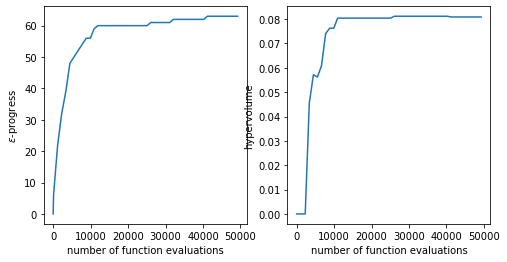

In [23]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

The number of function evaluations chosen for this assignment is 35000. This is not an optimal number, as can be seen above, but was chosen due to time constraints. 

hypervolume has mostly stabilised, epsilon-progress is only beginning to stabilise at 25000 evaluations. This suggests that the model should be re-run for 100,000 evaluations. This was not done here in the interests of time. 

##### Run the experiments for all the different scenarios identified

In [24]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_c, convergence = evaluator.optimize(nfe=nfe_value, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.01, 0.1],
                                    convergence=convergence_metrics,
                                    constraints=constraints, reference = scenario_2)
solutions_list.append(results_c)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 498/50000 nfe
[MainProcess/INFO] generation 10: 991/50000 nfe
[MainProcess/INFO] generation 15: 1488/50000 nfe
[MainProcess/INFO] generation 20: 1981/50000 nfe
[MainProcess/INFO] generation 25: 2476/50000 nfe
[MainProcess/INFO] generation 30: 2971/50000 nfe
[MainProcess/INFO] generation 35: 3464/50000 nfe
[MainProcess/INFO] generation 40: 3959/50000 nfe
[MainProcess/INFO] generation 45: 4455/50000 nfe
[MainProcess/INFO] generation 50: 4952/50000 nfe
[MainProcess/INFO] generation 55: 5449/50000 nfe
[MainProcess/INFO] generation 60: 5943/50000 nfe
[MainProcess/INFO] generation 65: 6441/50000 nfe
[MainProcess/INFO] generation 70: 6930/50000 nfe
[MainProcess/INFO] generation 75: 7424/50000 nfe
[MainProcess/INFO] generation 80: 7918/50000 nfe
[MainProcess/INFO] generation 85: 8409/50000 nfe
[MainProcess/INFO] generation 90: 8906/50000 nfe
[MainProcess/INFO] generation 95: 9399/50000

In [25]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_c, convergence = evaluator.optimize(nfe=nfe_value, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.01, 0.1],
                                    convergence=convergence_metrics,
                                    constraints=constraints, reference = scenario_3)
solutions_list.append(results_c)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 498/50000 nfe
[MainProcess/INFO] generation 10: 993/50000 nfe
[MainProcess/INFO] generation 15: 1488/50000 nfe
[MainProcess/INFO] generation 20: 1982/50000 nfe
[MainProcess/INFO] generation 25: 2476/50000 nfe
[MainProcess/INFO] generation 30: 2971/50000 nfe
[MainProcess/INFO] generation 35: 3458/50000 nfe
[MainProcess/INFO] generation 40: 3946/50000 nfe
[MainProcess/INFO] generation 45: 4438/50000 nfe
[MainProcess/INFO] generation 50: 4930/50000 nfe
[MainProcess/INFO] generation 55: 5427/50000 nfe
[MainProcess/INFO] generation 60: 5921/50000 nfe
[MainProcess/INFO] generation 65: 6418/50000 nfe
[MainProcess/INFO] generation 70: 6917/50000 nfe
[MainProcess/INFO] generation 75: 7416/50000 nfe
[MainProcess/INFO] generation 80: 7911/50000 nfe
[MainProcess/INFO] generation 85: 8404/50000 nfe
[MainProcess/INFO] generation 90: 8901/50000 nfe
[MainProcess/INFO] generation 95: 9399/50000

In [26]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_c, convergence = evaluator.optimize(nfe=nfe_value, searchover='levers',
                                    epsilons=[0.1, 0.1, 0.01, 0.1],
                                    convergence=convergence_metrics,
                                    constraints=constraints, reference = scenario_4)
solutions_list.append(results_c)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 5: 498/50000 nfe
[MainProcess/INFO] generation 10: 992/50000 nfe
[MainProcess/INFO] generation 15: 1488/50000 nfe
[MainProcess/INFO] generation 20: 1981/50000 nfe
[MainProcess/INFO] generation 25: 2475/50000 nfe
[MainProcess/INFO] generation 30: 2967/50000 nfe
[MainProcess/INFO] generation 35: 3460/50000 nfe
[MainProcess/INFO] generation 40: 3958/50000 nfe
[MainProcess/INFO] generation 45: 4457/50000 nfe
[MainProcess/INFO] generation 50: 4951/50000 nfe
[MainProcess/INFO] generation 55: 5447/50000 nfe
[MainProcess/INFO] generation 60: 5942/50000 nfe
[MainProcess/INFO] generation 65: 6439/50000 nfe
[MainProcess/INFO] generation 70: 6932/50000 nfe
[MainProcess/INFO] generation 75: 7426/50000 nfe
[MainProcess/INFO] generation 80: 7922/50000 nfe
[MainProcess/INFO] generation 85: 8418/50000 nfe
[MainProcess/INFO] generation 90: 8915/50000 nfe
[MainProcess/INFO] generation 95: 9407/50000

In [27]:
import pandas as pd
all_solutions = pd.concat([solutions_list[0], solutions_list[1], solutions_list[2], solutions_list[3]])
all_solutions = all_solutions.reset_index(drop = True)

In [28]:
chosen_solutions = []
chosen_solutions.append(all_solutions.max_P.idxmax())
chosen_solutions.append(all_solutions.max_P.idxmin())
chosen_solutions.append(all_solutions.utility.idxmax())
chosen_solutions.append(all_solutions.utility.idxmin())
chosen_solutions.append(all_solutions.inertia.idxmax())
chosen_solutions.append(all_solutions.inertia.idxmin())
chosen_solutions.append(all_solutions.reliability.idxmax())
chosen_solutions.append(all_solutions.reliability.idxmin())

In [29]:
solutions = all_solutions.iloc[chosen_solutions,:].drop_duplicates()

In [30]:
def max_regret(data):
    maximum = data.max()
    regret = []
    for value in data:
        temp = maximum - value
        regret.append(temp)
    return max(regret)

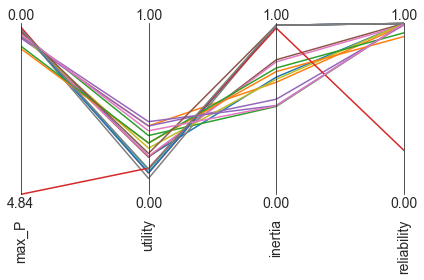

In [31]:
from ema_workbench.analysis import parcoords

data = all_solutions.loc[:, [o.name for o in lake_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0
limits.loc[1, ['utility', 'inertia', 'reliability']] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')
plt.show()

possbile candidate soltuions viusualised. Most solutions score high on polution, inertia and reliability. But score badly on utility. 

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


In [32]:
all_solutions

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.173977,0.165449,0.104163,1.633731,0.932460,0.197615,0.221516,0.6861,1.0000
1,0.387725,0.883250,0.054761,1.362925,0.359600,0.397917,0.400346,0.6561,0.9914
2,0.313763,0.408395,0.179542,1.813449,0.840277,0.264977,0.344143,0.5145,1.0000
3,0.215032,0.310583,0.526077,0.728372,0.929030,0.099576,0.124685,0.9900,1.0000
4,0.399497,0.007074,0.060069,1.417723,0.640199,0.410763,0.400057,0.5568,0.9912
5,0.257900,0.151917,0.043725,1.547979,0.098255,0.247106,0.217253,0.7876,1.0000
6,0.260600,0.304548,0.045077,1.700037,0.107087,0.283820,0.223379,0.7754,0.9908
7,0.057616,0.096738,0.191139,1.300855,0.042239,0.165903,0.093167,0.9898,1.0000
8,0.341815,0.329240,0.045834,1.803570,0.071979,0.316173,0.270676,0.6733,1.0000
9,0.242519,0.221795,0.173878,0.672120,0.132838,0.169891,0.143310,0.9900,1.0000


In [33]:
#select only the reliable solutions
new_results = all_solutions[all_solutions['reliability'] > 0.9]

In [34]:
# define policy designs of interest in a dict {key=lever, value=value}
inputs = ["c1", "c2", "r1", "r2", "w1"]
policies = []

for nr, entry in new_results.iterrows():
    policy_dict = {}
    
    for i in inputs:
        policy_dict[i] = entry[i]
    
    policies.append(Policy(policy_dict))

In [35]:
# evaluate these policies under 1000 scenarios

scenarios = 1000 
with MultiprocessingEvaluator(lake_model) as evaluator:
    newest_experiments, newest_outcomes = evaluator.perform_experiments(scenarios=scenarios, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 17 policies * 1 model(s) = 17000 experiments
[MainProcess/INFO] 1700 cases completed
[MainProcess/INFO] 3400 cases completed
[MainProcess/INFO] 5100 cases completed
[MainProcess/INFO] 6800 cases completed
[MainProcess/INFO] 8500 cases completed
[MainProcess/INFO] 10200 cases completed
[MainProcess/INFO] 11900 cases completed
[MainProcess/INFO] 13600 cases completed
[MainProcess/INFO] 15300 cases completed
[MainProcess/INFO] 17000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [36]:
# signal to ratio = mean / std

newest_outcomes_df = pd.DataFrame(newest_outcomes)
# Get the policy from each result
newest_outcomes_df['policy'] = newest_experiments['policy']
# Make the policy into a format I can group
newest_outcomes_df['policy'] = newest_outcomes_df['policy'].apply(lambda x: tuple(x.items()))
    # Change policy value to something more readable
temp_dict = {}
for i in range(len(newest_outcomes_df['policy'].unique())):
    temp_dict[newest_outcomes_df['policy'].unique()[i]] = i+1
newest_outcomes_df['policy'] = newest_outcomes_df['policy'].apply(lambda x: temp_dict[x])


In [37]:
# Make calculations

mean_df = newest_outcomes_df.groupby(by='policy').mean()
std_df = newest_outcomes_df.groupby(by='policy').std()

signal_ratio_df = pd.DataFrame(columns = ['max_P', 'reliability', 'inertia', 'utility'])

signal_ratio_df['max_P'] = mean_df['max_P'] / std_df['max_P']
signal_ratio_df['utility'] = mean_df['utility'] / std_df['utility']
signal_ratio_df['inertia'] = mean_df['inertia'] / std_df['inertia']
signal_ratio_df['reliability'] = mean_df['reliability'] / std_df['reliability']
signal_ratio_df

,max_P,reliability,inertia,utility
policy,,,,
1,0.690442,1.868019,120.100614,1.092800
2,0.690342,1.868000,120.603060,1.092651
3,0.690528,1.867736,120.487669,1.092840
4,0.690504,1.868346,120.168214,1.092761
5,0.690159,1.867899,120.328388,1.092646
6,0.690202,1.867419,120.456857,1.092831
7,0.690248,1.868143,120.298565,1.092776
8,0.690398,1.867982,120.377249,1.092730
9,0.690417,1.867891,120.411187,1.092765


##### Now visualize these results in a signal-to-noise ratio per policy

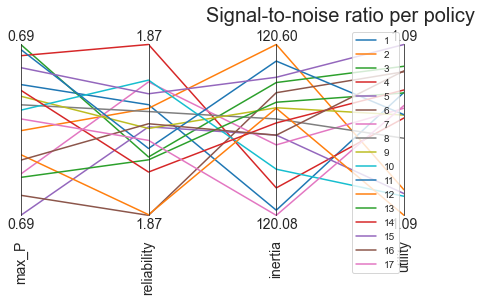

In [38]:
limits = parcoords.get_limits(signal_ratio_df)
axes = parcoords.ParallelAxes(limits)
axes.plot(signal_ratio_df)

plt.legend(signal_ratio_df.index.values)
plt.title('Signal-to-noise ratio per policy', fontsize=20)
plt.show()

The graph shows not a lot of variance. Why this is the case is something that we have to look at. 

Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


In [39]:
# Get the most desirable values for each result
best_results = {'max_P': 0, 'reliability': 1, 'inertia': 1, 'utility': newest_outcomes_df['utility'].max()}
# Is there a better way to get the maximum utility?????

# Calculate regret
regret_df = pd.DataFrame(columns = ['max_P', 'reliability', 'inertia', 'utility','policy'])
regret_df['max_P'] = newest_outcomes_df['max_P'] - best_results['max_P']
regret_df['reliability'] = best_results['reliability'] - newest_outcomes_df['reliability']
regret_df['inertia'] = best_results['inertia'] - newest_outcomes_df['inertia']
regret_df['utility'] = best_results['utility'] - newest_outcomes_df['utility']
regret_df['policy'] = newest_outcomes_df['policy']
regret_df = regret_df.groupby(by='policy').max()

regret_df

,max_P,reliability,inertia,utility
policy,,,,
1,11.364914,0.9887,0.03,2.232213
2,11.363282,0.9889,0.03,2.232176
3,11.363588,0.9890,0.03,2.232212
4,11.363330,0.9886,0.03,2.232190
5,11.364433,0.9883,0.03,2.232201
6,11.364224,0.9888,0.03,2.232191
7,11.363757,0.9887,0.03,2.232191
8,11.364143,0.9890,0.03,2.232206
9,11.364720,0.9885,0.03,2.232174


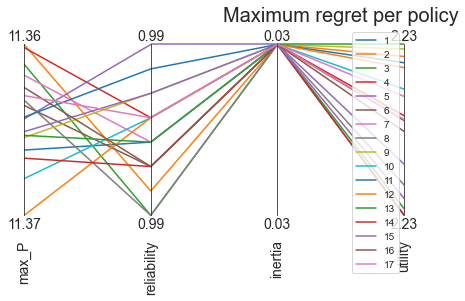

In [40]:
limits = parcoords.get_limits(regret_df)
axes = parcoords.ParallelAxes(limits)
axes.plot(regret_df)

# invert axes so it is more intuitive to read, higher regret is down, so higher desirability is up
axes.invert_axis(['max_P', 'reliability', 'inertia', 'utility']) 
plt.legend(regret_df.index.values)
plt.title('Maximum regret per policy', fontsize=20)
plt.show()

The maximum regret for each policy vaires greatly for the different criteria. Reliability seems to have a strong tendency to the upper ranges. 

In [41]:
domain_criterion_1 = []
for i in range(0,700,100):
    x = newest_outcomes["reliability"][i:i+100] >= 0.8
    domain_criterion_reliability = np.sum(x) / len(x)
    domain_criterion_1.append(domain_criterion_reliability)

In [42]:
domain_criterion_2 = []
for i in range(0,700,100):
    x = newest_outcomes["utility"][i:i+100] >= 0.75
    domain_criterion_utility = np.sum(x) / len(x)
    domain_criterion_2.append(domain_criterion_utility)

In [43]:
domain_criterion_3 = []
for i in range(0,700,100):
    x = newest_outcomes["inertia"][i:i+100] >= 0.99
    domain_criterion_inertia = np.sum(x) / len(x)
    domain_criterion_3.append(domain_criterion_inertia)

In [44]:
domain = pd.DataFrame({"policy" : [1,2,3,4,5,6,7], "utility" : domain_criterion_2, "inertia" : domain_criterion_3, "reliability" : domain_criterion_1})

In [45]:
domain

,policy,utility,inertia,reliability
0,1,0.12,0.69,0.70
1,2,0.12,0.71,0.71
2,3,0.14,0.67,0.67
3,4,0.16,0.67,0.67
4,5,0.16,0.67,0.67
5,6,0.12,0.69,0.69
6,7,0.15,0.65,0.65


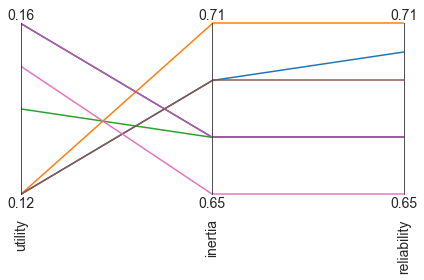

In [46]:
from ema_workbench.analysis import parcoords
outcomes_domain = domain.loc[:,["utility", "inertia","reliability"]]
limits = parcoords.get_limits(outcomes_domain)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes_domain)

# we invert this axis so direction of desirability is the same 
#axes.invert_axis('max_P') 
plt.show()